# Tutorial 2 for *BiLO: Bi-Level Local Operator for PDE inverse problem*

#### Inferring unknown function.

In this example, we solve the inverse problem

$$
\begin{aligned}
& \min_{D} \sum_{i=1}^n(u(x_i) - u_{\text{obs}}(x_i))^2\\
& \text{s.t.   }\quad (D(x)u'(x))' = f(x), \quad u(0) = 0, \quad u(1) = 0,
\end{aligned}
$$

where $u_{\text{obs}}$ is the observed data, $u$ is the solution, and $f$ is the known source term and $D(x)$ is an unknown function, e.g. spatially dependent diffusion coefficient.


In [39]:
import sys
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# set seed
torch.manual_seed(0)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [40]:
class DenseNet(nn.Module):
    '''General class for a dense neural network with a variable number of layers and width.'''
    def __init__(self, depth=4, width=64, 
                 output_transform=lambda x, u: u):
        super(DenseNet, self).__init__()
        input_dim = 1
        output_dim = 1
        self.width = width
        self.depth = depth
        self.activation = torch.tanh
        layers = []

        # input layer/embeding layer
        self.input_layer = nn.Linear(input_dim, width)

        # hidden layers (depth - 2)
        self.hidden_layers = nn.ModuleList([nn.Linear(width, width) for _ in range(depth - 2)])
        self.output_layer = nn.Linear(width, output_dim)
        
        # Store the output transformation function
        self.output_transform = output_transform
    

    def forward(self, x):
        # Define the forward pass
        act = self.activation
        u = act(self.input_layer(x))
        for layer in self.hidden_layers:
            u = act(layer(u))
        u = self.output_layer(u)
        
        return self.output_transform(x, u)


In [41]:
def fdm(D, f, x):
    """
    Solve (D(x)*u'(x))' = f(x) on [0,1] with u(0)=u(1)=0 using finite differences
    on a uniform grid.
    """
    # Convert torch tensors to NumPy arrays (assumes they are on CPU)
    D_np = np.asarray(D.detach().cpu().numpy()).ravel()
    f_np = np.asarray(f.detach().cpu().numpy()).ravel()
    x_np = np.asarray(x.detach().cpu().numpy()).ravel()
    
    N = len(x_np)
    u = np.zeros(N, dtype=float)
    u[0] = 0.0
    u[-1] = 0.0
    
    # If there are no interior points, return the boundaries.
    if N <= 2:
        return torch.from_numpy(u)
    
    # Uniform grid spacing
    h = x_np[1] - x_np[0]
    
    M = N - 2  # number of interior unknowns
    A = np.zeros((M, M), dtype=float)
    rhs = np.zeros(M, dtype=float)
    
    # Loop over interior nodes (i = 1,...,N-2).
    for j in range(M):
        i = j + 1  # index in the full grid corresponding to the interior node
        # Diffusivities at the half points
        D_left = (D_np[i-1] + D_np[i]) / 2.0    # D_{i-1/2}
        D_right = (D_np[i] + D_np[i+1]) / 2.0    # D_{i+1/2}
        
        # assemble the matrix A and right-hand side vector
        A[j, j] = - (D_left + D_right)
        
        if j > 0:
            A[j, j-1] = D_left
        if j < M - 1:
            A[j, j+1] = D_right
        
        rhs[j] = h**2 * f_np[i]
    
    # Incorporate the boundary conditions:
    # For the first interior node (i=1, j=0): add the known term from u(0)
    D_left_first = (D_np[0] + D_np[1]) / 2.0
    rhs[0] += D_left_first * u[0]  # u[0] = 1
    
    # For the last interior node (i=N-2, j=M-1): add the known term from u(1)
    D_right_last = (D_np[N-2] + D_np[N-1]) / 2.0
    rhs[-1] += D_right_last * u[-1]  # u[-1] = 1
    
    # Solve the linear system
    u_interior = np.linalg.solve(A, rhs)
    u[1:-1] = u_interior
    
    # Convert the solution back to a torch tensor before returning.
    return torch.from_numpy(u)

In [42]:
from math import pi, sin
class FunctionPoisson():
    def __init__(self):
        # GT hat function
        self.D = lambda x: 1 + 0.5 * (1 - 2*torch.abs(x-0.5))

        # initaial guess constant
        self.D0 = lambda x: torch.ones_like(x)
        self.dataset = {}
    
    def f(self, x):
        ''' fixed forcing term'''
        return -(torch.pi)**2 * torch.sin(torch.pi * x)

    def u_exact(self, x, D):
        ''' exact PDE solution for given D '''
        # convert to numpy
        f = self.f(x)
        # if D is function
        if callable(D):
            D = D(x) 

        u = fdm(D, f, x)
        return u.view(-1, 1)
    
    def get_dataset(self, N_res_train, N_dat_train,  N_test, variance = None):
        ''' Generate a dataset for the scalar Poisson equation.'''
    
        self.N_res_train = N_res_train
        self.N_dat_train = N_dat_train

        # find grid to compute exact solution
        self.N_test = N_test

        # Collocation points for residual loss
        self.dataset['x_res_train'] = torch.linspace(0, 1, N_res_train).view(-1, 1)

        # Collocation points for data loss
        self.dataset['x_dat_train'] = torch.linspace(0, 1, N_dat_train).view(-1, 1)

        # Test points
        self.dataset['x_test'] = torch.linspace(0, 1, N_test).view(-1, 1)
        
        # use exact D for testing
        self.dataset['Dgt_test'] = self.D(self.dataset['x_test'])
        self.dataset['ugt_test'] = self.u_exact(self.dataset['x_test'], self.D)

        # D0 for pretraining
        self.dataset['D0_test'] = self.D0(self.dataset['x_test'])
        self.dataset['u0_test'] = self.u_exact(self.dataset['x_test'], self.D0)

        # u at ground truth D for training
        u = self.u_exact(self.dataset['x_dat_train'], self.D)

        # add noise to the data if variance is not None
        if variance is None:
            noise = 0
        else:
            noise = torch.randn_like(u) *  torch.sqrt(torch.tensor(variance))
        
        # (noisy) data for fine-tuning
        self.dataset['u_dat_train'] = u + noise

    def to_device(self, device):
        # move all data to device
        for key in self.dataset:
            self.dataset[key] = self.dataset[key].to(device)


In [43]:
class LocalOperator(DenseNet):
    '''
    represent u(x, z), where z = D(x)
    '''
    def __init__(self, fdepth=4, fwidth=64, 
                 output_transform=lambda x, u: u):
        super().__init__(fdepth, fwidth, output_transform)

        # embedding layer
        self.param_embeddings = nn.Linear(1, self.width, bias=True)
        # set requires_grad to False
        for embedding_weights in self.param_embeddings.parameters():
            embedding_weights.requires_grad = False
        
        self.params_expand = None

    def embedding(self, x, z):
        # Embedding layer for the coordinate x and z = D(x)
        # This layer compute Wx + Rz
        
        xcoord  = x
        x = self.input_layer(x)

        self.params_expand = z
        param_embedding = self.param_embeddings(self.params_expand)
        x += param_embedding
        return x

    def forward(self, x , z):
        # Define the forward pass
        X = self.embedding(x, z)
        X = self.activation(X)
        for layer in self.hidden_layers:
            X = self.activation(layer(X))
        u = self.output_layer(X)
        
        return self.output_transform(x, u)

class Bilo(nn.Module):
    def __init__(self, localOp, pde):
        super(Bilo, self).__init__()
        
        self.localOp = localOp
        self.pde = pde
        self.dataset = pde.dataset

        # lower level parameters W of u(x,z; W)
        self.param_net = [v for v in self.localOp.parameters() if v.requires_grad]

        # parameterized function D(x;V)
        self.D_fun = DenseNet(4, 64, output_transform=lambda x, u: 1.0 + u * (1 - x) *x)

        # upper level parameters V of D(x;V)
        self.param_pde = list(self.D_fun.parameters())

        self.wresgrad = 1e-3

    def residual_grad_loss(self):
        '''
        Compute residual loss and the gradient of the residual loss w.r.t. the pde parameter
        '''
        x = self.dataset['x_res_train']
        x.requires_grad = True
        D = self.D_fun(x)
        u = self.localOp(x, D)

        u_x = torch.autograd.grad(u, x,
            create_graph=True, retain_graph=True, grad_outputs=torch.ones_like(u))[0]
        u_xx = torch.autograd.grad(D * u_x, x,
            create_graph=True, retain_graph=True, grad_outputs=torch.ones_like(u_x))[0]

        res = u_xx - self.pde.f(x)

        # gradient of the residual
        resgrad = torch.autograd.grad(res, self.localOp.params_expand, grad_outputs=torch.ones_like(res),
        create_graph=True, allow_unused=True)[0]
        
        # 2norm of the residual
        res_loss = torch.mean(res**2)
        # 2norm of the gradient of the residual
        res_grad_loss = torch.mean(resgrad**2)
        
        return  res_loss, res_grad_loss

    def pretrained_data_loss(self):
        # MSE between D0 and D
        x  = self.dataset['x_test']
        Dpred = self.D_fun(x)

        D_dat = self.dataset['D0_test']
        loss = torch.mean((Dpred - D_dat)**2)
        return loss    

    def finetune_data_loss(self):
        # MSE between u_pred and u_dat
        x  = self.dataset['x_dat_train']
        u  = self.localOp(x, self.D_fun(x))

        u_dat = self.dataset['u_dat_train']
        loss = torch.mean((u - u_dat)**2)
        return loss
    
    def pretrain(self, max_iter):
        # all parameters are trainable
        optimizer = torch.optim.Adam(self.localOp.parameters(), lr=1e-3)
        for step in range(max_iter):
            optimizer.zero_grad()
            res_loss, resgrad_loss = self.residual_grad_loss()
            data_loss = self.pretrained_data_loss()
            
            total_loss = res_loss + self.wresgrad * resgrad_loss + data_loss
            total_loss.backward()
            optimizer.step()
            if step % 100 == 0:
                print(f'Step {step}, res_loss: {res_loss.item():.3e}, resgrad_loss: {resgrad_loss.item():.3e}, data_loss: {data_loss.item():.3e}')  
            
    
    def finetune(self, max_iter, lr_upper=1e-3, lr_lower=1e-3):
        # Bilevel optimization with simultaneous gradient descent
        optim_param_group = [
                {'params': self.param_net, 'lr': lr_lower},
                {'params': self.param_pde, 'lr': lr_upper}
            ]
        optimizer = torch.optim.Adam(optim_param_group)

        for step in range(max_iter):
            
            # compute the gradient of the upper level data loss w.r.t. the PDE parameter, V of D(x;V)
            data_loss = self.finetune_data_loss()
            grads_param = torch.autograd.grad(data_loss, self.param_pde, create_graph=False)
            for i, param in enumerate(self.param_pde):
                param.grad = grads_param[i]
            
            # compute the gradient of the lower level local operator loss w.r.t. the network parameters, W of u(x,z;W)
            res_loss, resgrad_loss = self.residual_grad_loss()
            lo_loss = res_loss + resgrad_loss * self.wresgrad
            grads_net = torch.autograd.grad(lo_loss, self.param_net, create_graph=False)
            for i, param in enumerate(self.param_net):
                param.grad = grads_net[i]
            
            # simultaneous gradient descent at both levels
            optimizer.step()
            if step % 100 == 0:
                D_pred = self.D_fun(self.dataset['x_test'])
                D_inf = torch.max(torch.abs(D_pred - self.dataset['Dgt_test']))
                print(f'Step {step}, res_loss: {res_loss.item():.3e}, resgrad_loss: {resgrad_loss.item():.3e}, data_loss: {data_loss.item():.3e}, D_inf: {D_inf.item():.3f}')

In [44]:
# training colloction points
n_res_train = 101 # number of collocation points for residual loss
n_dat_train = 101 # number of collocation points for data loss
n_test = 101  # number of collocation points for plotting

pde = FunctionPoisson()
pde.get_dataset(n_res_train, n_dat_train, n_test, variance=None)

### Pre-training

In the pre-training stage, we train BiLO with initial guess $D_0(x) = 1$.

(0.8, 1.5)

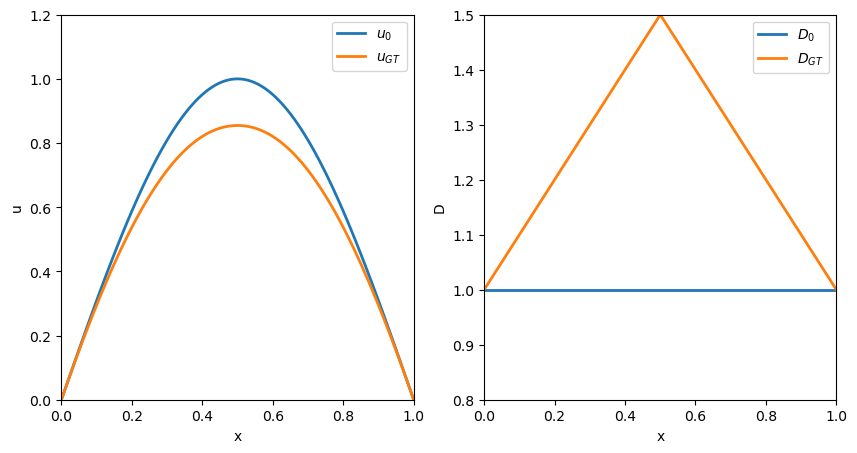

In [45]:
# plot initial and ground truth

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].plot(pde.dataset['x_test'], pde.dataset['u0_test'], label='$u_0$', linewidth=2)
ax[0].plot(pde.dataset['x_test'], pde.dataset['ugt_test'], label='$u_{GT}$', linewidth=2)
ax[0].legend()
ax[0].set_xlabel('x')
ax[0].set_ylabel('u')

ax[0].set_xlim([0, 1])
ax[0].set_ylim([0, 1.2])

ax[1].plot(pde.dataset['x_test'], pde.dataset['D0_test'], label='$D_0$', linewidth=2)
ax[1].plot(pde.dataset['x_test'], pde.dataset['Dgt_test'], label='$D_{GT}$',linewidth=2)
ax[1].legend()
ax[1].set_xlabel('x')
ax[1].set_ylabel('D')

ax[1].set_xlim([0, 1])
ax[1].set_ylim([0.8, 1.5])

In [46]:
localop = LocalOperator(fdepth=4, fwidth=128, output_transform=lambda x, u: u * (1 - x)*x)
bilo = Bilo(localop, pde).to(device)
pde.to_device(device)

In [47]:
bilo.wresgrad = 0.001
max_iter = 2000
bilo.pretrain(max_iter)

Step 0, res_loss: 4.815e+01, resgrad_loss: 1.280e-02, data_loss: 2.557e-03
Step 100, res_loss: 5.920e-03, resgrad_loss: 8.951e+01, data_loss: 2.557e-03
Step 200, res_loss: 1.167e-03, resgrad_loss: 7.561e+01, data_loss: 2.557e-03
Step 300, res_loss: 1.123e-03, resgrad_loss: 6.373e+01, data_loss: 2.557e-03
Step 400, res_loss: 1.078e-03, resgrad_loss: 5.350e+01, data_loss: 2.557e-03
Step 500, res_loss: 9.811e-04, resgrad_loss: 4.411e+01, data_loss: 2.557e-03
Step 600, res_loss: 8.511e-04, resgrad_loss: 3.445e+01, data_loss: 2.557e-03
Step 700, res_loss: 7.116e-04, resgrad_loss: 2.347e+01, data_loss: 2.557e-03
Step 800, res_loss: 6.120e-04, resgrad_loss: 1.175e+01, data_loss: 2.557e-03
Step 900, res_loss: 5.724e-04, resgrad_loss: 3.499e+00, data_loss: 2.557e-03
Step 1000, res_loss: 5.132e-04, resgrad_loss: 5.678e-01, data_loss: 2.557e-03
Step 1100, res_loss: 4.194e-04, resgrad_loss: 6.429e-02, data_loss: 2.557e-03
Step 1200, res_loss: 3.245e-04, resgrad_loss: 9.884e-03, data_loss: 2.557e-0

### Visualizing BILO
After pre-training at $D_0(x)=1$, we can evaluate the local operator at its neighborhood $D_0(x) + \delta D(x)$.
The local operator is able to approximate the true PDE solution at the neighborhood of $D_0(x)$.

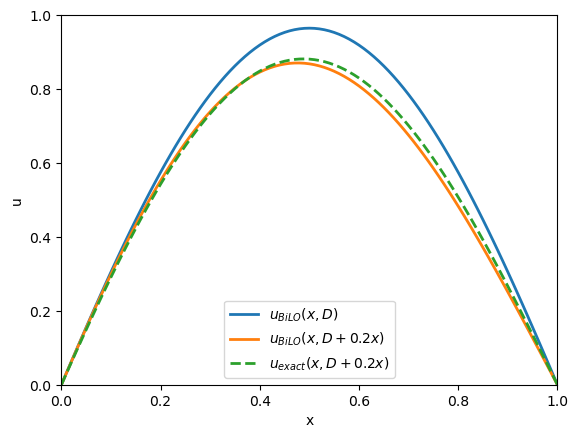

In [48]:
with torch.no_grad():
    x = pde.dataset['x_test']
    # plot prediction
    D = bilo.D_fun(x)
    u = bilo.localOp(x, D)
    plt.plot(x.cpu().numpy(), u.cpu().numpy(), label='$u_{BiLO}(x,D)$', linewidth=2)
    
    # variation of D
    delta =  0.2*x
    
    # evaluate BILO variation of D
    u_var = bilo.localOp(x, D + delta)
    u_exact_var = pde.u_exact(x, D + delta)

    # plot prediction from BILO at D + delta
    plt.plot(x.cpu().numpy(), u_var.cpu().numpy(), label=f'$u_{{BiLO}}(x,D+0.2x)$',  linewidth=2)

    # plot exact solution with predicted D
    plt.plot(x.cpu().numpy(), u_exact_var.cpu().numpy(), label=f'$u_{{exact}}(x,D+0.2x)$', linewidth=2,linestyle='--',)

plt.xlabel('x')
plt.ylabel('u')

plt.xlim(0, 1)
plt.ylim(0, 1)

plt.legend()
plt.show()


### Fine-tuning/Inference
Next, we solve the inverse problem to infer D(x)

In [49]:
max_iter = 2000
bilo.finetune(max_iter,lr_upper=2e-3)

Step 0, res_loss: 2.664e-05, resgrad_loss: 1.225e-03, data_loss: 4.384e-03, D_inf: 0.365
Step 100, res_loss: 5.017e-04, resgrad_loss: 6.043e+00, data_loss: 1.002e-05, D_inf: 0.180
Step 200, res_loss: 1.003e-04, resgrad_loss: 3.148e+00, data_loss: 9.500e-06, D_inf: 0.178
Step 300, res_loss: 5.015e-05, resgrad_loss: 1.729e+00, data_loss: 9.073e-06, D_inf: 0.177
Step 400, res_loss: 3.729e-05, resgrad_loss: 7.211e-01, data_loss: 8.300e-06, D_inf: 0.174
Step 500, res_loss: 8.015e-05, resgrad_loss: 1.403e-01, data_loss: 6.646e-06, D_inf: 0.168
Step 600, res_loss: 5.834e-04, resgrad_loss: 6.017e-01, data_loss: 3.706e-06, D_inf: 0.152
Step 700, res_loss: 1.199e-03, resgrad_loss: 3.647e+00, data_loss: 8.983e-07, D_inf: 0.121
Step 800, res_loss: 5.159e-03, resgrad_loss: 6.621e+00, data_loss: 3.167e-06, D_inf: 0.098
Step 900, res_loss: 2.641e-04, resgrad_loss: 3.975e+00, data_loss: 8.161e-08, D_inf: 0.088
Step 1000, res_loss: 4.147e-04, resgrad_loss: 6.405e+00, data_loss: 1.437e-07, D_inf: 0.085


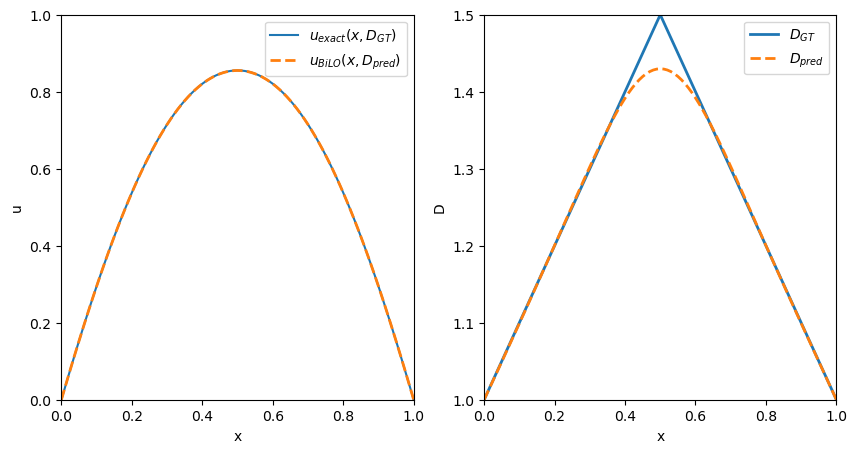

In [50]:
# plot predicted D(x) and ground truth D(x)
pde.to_device('cpu')
bilo.to('cpu')
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
with torch.no_grad():
    x = pde.dataset['x_test']
    # predicted u and ground truth u
    D = bilo.D_fun(x)
    u = bilo.localOp(x, D)

    # plot predicted u
    ax[0].plot(x, pde.u_exact(x, D), label='$u_{exact}(x,D_{GT})$')
    ax[0].plot(x, u, label='$u_{BiLO}(x,D_{pred})$', linestyle='--',linewidth=2)
    ax[0].legend()

    # labels
    ax[0].set_xlabel('x')
    ax[0].set_ylabel('u')
    ax[0].set_xlim(0, 1)
    ax[0].set_ylim(0, 1)

    # plot predicted D
    ax[1].plot(x, pde.D(x), label='$D_{GT}$', linewidth=2)
    ax[1].plot(x, D, label='$D_{pred}$', linestyle='--',linewidth=2)
    # legend
    ax[1].legend()
    
    # labels
    ax[1].set_xlabel('x')
    ax[1].set_ylabel('D')
    ax[1].set_xlim(0, 1)
    ax[1].set_ylim(1, 1.5)
